In [4]:
import pysr
import sympy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from pysr import PySRRegressor
from sklearn. model_selection import train_test_split
from scipy import special
from scipy.special import erf, erfc
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.lines as mlines
from matplotlib import rc
from matplotlib.ticker import LogFormatter

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# Dataset
base_path = "/Users/yuangw/Documents/GitHub/GBF/multispin/"  # Use relative path
GBF_10_10 = np.loadtxt(base_path + "GBF_s=1_l=1.txt")
GBF_10_20 = np.loadtxt(base_path + "GBF_s=1_l=2.txt")
GBF_10_30 = np.loadtxt(base_path + "GBF_s=1_l=3.txt")
GBF_10_40 = np.loadtxt(base_path + "GBF_s=1_l=4.txt")
s10x, s10l0, s10l1, s10l2, s10l3 = GBF_10_10[:, 0], GBF_10_10[:, 1], GBF_10_20[:, 1], GBF_10_30[:, 1], GBF_10_40[:, 1]
np.savetxt("multispin/GBF_s=10.txt", np.c_[s10x, s10l0, s10l1, s10l2, s10l3])
s10_array = np.column_stack((s10l0, s10l1, s10l2, s10l3))

## 10% noise level in both $\Omega_i$ and $\Gamma_i$

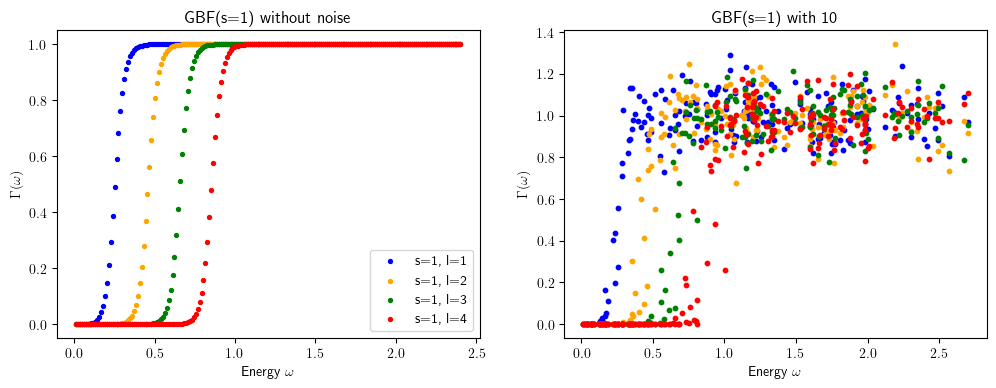

In [5]:
# Define Gaussian noise
mean = 0 
std_dev10 = 0.1  # 10% noise level in both omega and GBF
s10x_noise10 = s10x + np.random.normal(mean, std_dev10*s10x)
y1_noise10 = s10l0 + np.random.normal(mean, std_dev10*s10l0, size=s10l0.shape)
y2_noise10 = s10l1 + np.random.normal(mean, std_dev10*s10l1, size=s10l1.shape)
y3_noise10 = s10l2 + np.random.normal(mean, std_dev10*s10l2, size=s10l2.shape)
y4_noise10 = s10l3 + np.random.normal(mean, std_dev10*s10l3, size=s10l3.shape)
y_noise10 = np.column_stack((y1_noise10, y2_noise10, y3_noise10, y4_noise10)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise10, y_noise10[:, 0], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise10, y_noise10[:, 1], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise10, y_noise10[:, 2], color='green', marker='o', s=10)
axs[1].scatter(s10x_noise10, y_noise10[:, 3], color='red', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with 10% Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 10% errorbar

In [6]:
# Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise10, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise10.flatten()

print(np.shape(input_data), np.shape(y_noise10), np.shape(y_flat))

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model10 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model10.fit(input_data, y_flat)

(800, 2) (200, 4) (800,)
Compiling Julia backend...


/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.110e+05
Head worker occupation: 5.3%
Progress: 721 / 7500 total iterations (9.613%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.508e-01  1.594e+01  y = 0.23724
3           1.702e-01  4.870e-01  y = 0.35761 - -0.40933
4           6.908e-02  9.017e-01  y = sin(x₀)
5           5.835e-02  1.688e-01  y = erf(x₀)
7           5.763e-02  6.248e-03  y = erf(x₀ + -0.044345)
9           5.656e-02  9.375e-03  y = erf(x₀ - 0.099739) - -0.04786
10          4.956e-02  1.321e-01  y = erf((x₀ + x₀) / x₁)
11          4.049e-02  2.021e-01  y = erf((x₀ / 0.37584) / x₁)
12          3.629e-02  1.094e-01  y = erf(x₀ * ((3.689 - x₁) + x₀))
13          2.912e-02  2.202e-01  y = erf(((x₀ * 4.039) / x₁) - 0.33824)
14          2.612e-02  1.087e-01  y = erf((x₀ - 0.13332) * (x₀ + (3.689 - x₁)))
15          2.442e-02  6.735e-02  y = erf((3.689 - (x₁ - x₀)

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          0.7669296   
	1         2.937531e-08                              1.4869025 + -0.719973   
	2         9.017448e-01                                            sin(x0)   
	3         1.688198e-01                                            erf(x0)   
	4         6.247727e-03                               erf(x0 - 0.04434478)   
	5         9.375195e-03                erf(x0 - 0.09973943) - -0.047860257   
	6         1.320943e-01                                erf((x0 + x0) / x1)   
	7         2.020827e-01                         erf((2.6603758 * x0) / x1)   
	8         1.720974e-01                  erf(x0 * (3.5170918 - (x1 - x0)))   
	9   >>>>  9.012718e-01                    erf(exp(3.8640454 - (x1 / x0)))   
	10        4.347162e-02            erf(exp(x0 - (-3.1766744 + (x1 / x0))))   
	11        3.873730e-03  erf(exp(x0 - (-3.218367 + (x1 / x0))) + -0.020...   
	12        4.213140e-02  erf(exp(-1.4704984 * (((x1 + 0.2833658) / x0) ...   
	13        4.941332e-03  erf(exp((((x0 - 0.095053524) * -4.908437) + x1...   
	
	        loss  complexity  
	0   0.170211           1  
	1   0.170211           3  
	2   0.069082           4  
	3   0.058351           5  
	4   0.057626           7  
	5   0.056556           9  
	6   0.049558          10  
	7   0.040490          11  
	8   0.034088          12  
	9   0.013842          13  
	10  0.012689          15  
	11  0.012591          17  
	12  0.012072          18  
	13  0.011953          20  
]

In [7]:
SchGBF_model10.sympy()

erf(exp(3.8640454 - x1/x0))

### The fitting result of SR with 10%

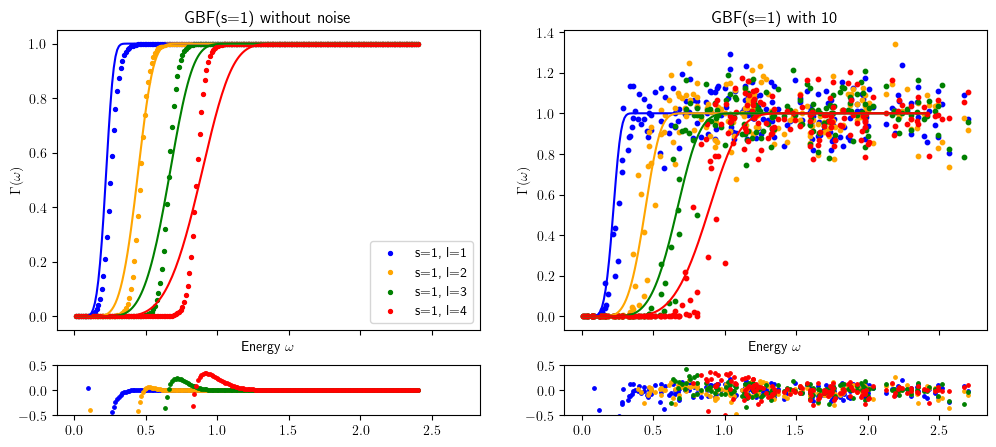

In [8]:
def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr10(s10x, 1), color='blue')
axs[0,0].plot(s10x, GBFsr10(s10x, 2), color='orange')
axs[0,0].plot(s10x, GBFsr10(s10x, 3), color='green')
axs[0,0].plot(s10x, GBFsr10(s10x, 4), color='red')

axs[0,0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr10(s10x, 1))/s10l0, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr10(s10x, 2))/s10l1, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr10(s10x, 3))/s10l2, color='green', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr10(s10x, 4))/s10l3, color='red', s=6)
axs[1,0].set_ylim(-0.5, 0.5)

axs[0,1].plot(s10x, GBFsr10(s10x, 1), color='blue')
axs[0,1].plot(s10x, GBFsr10(s10x, 2), color='orange')
axs[0,1].plot(s10x, GBFsr10(s10x, 3), color='green')
axs[0,1].plot(s10x, GBFsr10(s10x, 4), color='red')

axs[0,1].scatter(s10x_noise10, y_noise10[:, 0], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise10, y_noise10[:, 1], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise10, y_noise10[:, 2], color='green', marker='o', s=10)
axs[0,1].scatter(s10x_noise10, y_noise10[:, 3], color='red', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 10% Gaussian noise")

axs[1,1].scatter(s10x_noise10, (y_noise10[:, 0]-GBFsr10(s10x, 1))/y_noise10[:, 0], color='blue', s=6)
axs[1,1].scatter(s10x_noise10, (y_noise10[:, 1]-GBFsr10(s10x, 2))/y_noise10[:, 1], color='orange', s=6)
axs[1,1].scatter(s10x_noise10, (y_noise10[:, 2]-GBFsr10(s10x, 3))/y_noise10[:, 2], color='green', s=6)
axs[1,1].scatter(s10x_noise10, (y_noise10[:, 3]-GBFsr10(s10x, 4))/y_noise10[:, 3], color='red', s=6)
axs[1,1].set_ylim(-0.5, 0.5)

plt.show()

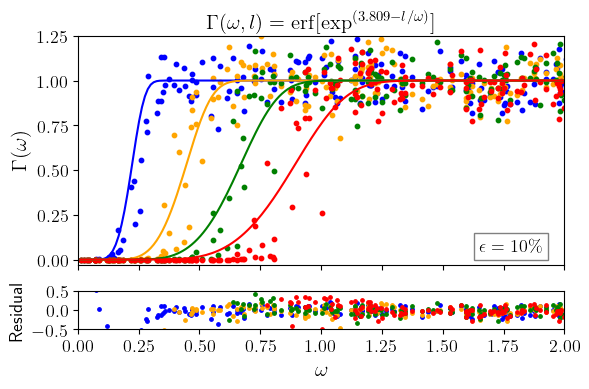

In [70]:
def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )

fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0].plot(s10x, GBFsr10(s10x, 1), color='blue')
axs[0].plot(s10x, GBFsr10(s10x, 2), color='orange')
axs[0].plot(s10x, GBFsr10(s10x, 3), color='green')
axs[0].plot(s10x, GBFsr10(s10x, 4), color='red')

axs[0].scatter(s10x_noise10, y_noise10[:, 0], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise10, y_noise10[:, 1], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise10, y_noise10[:, 2], color='green', marker='o', s=10)
axs[0].scatter(s10x_noise10, y_noise10[:, 3], color='red', marker='o', s=10)
axs[0].set_xlim(0, 2)
axs[0].set_ylim(-0.03, 1.25)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.65, 0.05, r'$\epsilon=10\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erf}[{\rm exp}^{(3.809 - l/\omega)} ]$', fontsize=15)

axs[1].scatter(s10x_noise10, (y_noise10[:, 0]-GBFsr10(s10x, 1))/y_noise10[:, 0], color='blue', s=6)
axs[1].scatter(s10x_noise10, (y_noise10[:, 1]-GBFsr10(s10x, 2))/y_noise10[:, 1], color='orange', s=6)
axs[1].scatter(s10x_noise10, (y_noise10[:, 2]-GBFsr10(s10x, 3))/y_noise10[:, 2], color='green', s=6)
axs[1].scatter(s10x_noise10, (y_noise10[:, 3]-GBFsr10(s10x, 4))/y_noise10[:, 3], color='red', s=6)
axs[1].set_xlabel("$\omega$", fontsize=15)
axs[1].set_ylabel("Residual", fontsize=13)
axs[1].set_ylim(-0.5, 0.5)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err10.pdf", bbox_inches='tight')
plt.show()

## 5% noise level in both $\Omega_i$ and $\Gamma_i$

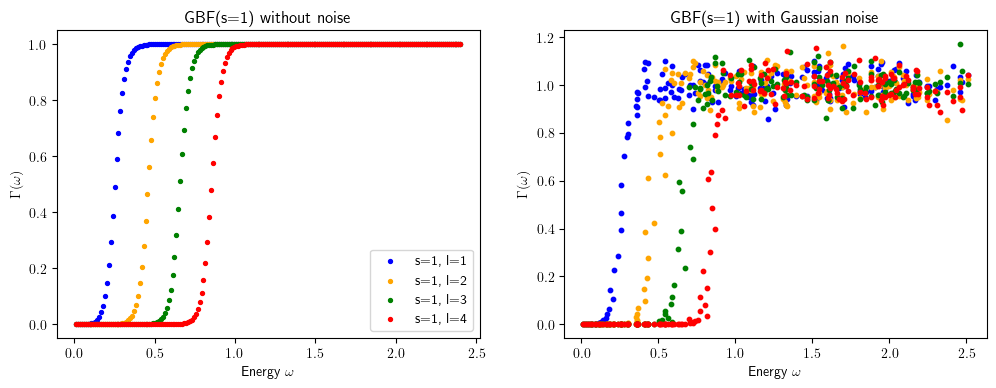

In [10]:
# Define Gaussian noise
mean = 0 
std_dev05 = 0.05  # 1% noise level in both omega and GBF
s10x_noise05 = s10x + np.random.normal(mean, std_dev05*s10x)
y1_noise05 = s10l0 + np.random.normal(mean, std_dev05*s10l0, size=s10l0.shape)
y2_noise05 = s10l1 + np.random.normal(mean, std_dev05*s10l1, size=s10l1.shape)
y3_noise05 = s10l2 + np.random.normal(mean, std_dev05*s10l2, size=s10l2.shape)
y4_noise05 = s10l3 + np.random.normal(mean, std_dev05*s10l3, size=s10l3.shape)
y_noise05 = np.column_stack((y1_noise05, y2_noise05, y3_noise05, y4_noise05)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise05, y_noise05[:, 0], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise05, y_noise05[:, 1], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise05, y_noise05[:, 2], color='green', marker='o', s=10)
axs[1].scatter(s10x_noise05, y_noise05[:, 3], color='red', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 5% errorbar

In [11]:
# Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise05, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise05.flatten()

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model05 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model05.fit(input_data, y_flat)

/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.190e+05
Head worker occupation: 6.4%
Progress: 741 / 7500 total iterations (9.880%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.698e-01  1.594e+01  y = 0.82633
3           1.666e-01  9.455e-03  y = -0.51342 + 1.2834
4           5.836e-02  1.049e+00  y = sin(x₀)
5           5.250e-02  1.057e-01  y = erf(x₀)
7           5.140e-02  1.057e-02  y = erf(x₀ + -0.054975)
9           5.015e-02  1.230e-02  y = erf(x₀ - 0.11381) - -0.051208
10          4.440e-02  1.217e-01  y = erf((x₀ + x₀) / x₁)
11          3.603e-02  2.091e-01  y = erf(x₀ / (0.38025 * x₁))
12          3.340e-02  7.583e-02  y = erf(((x₀ / x₁) - 0.27795) + x₀)
13          2.423e-02  3.208e-01  y = erf((x₀ / (0.24991 * x₁)) - 0.3364)
14          2.159e-02  1.152e-01  y = erf(x₀ / ((0.25046 * x₁) / x₀))
15          1.688e-02  2.464e-01  y = erf(x₀ * (exp(x₀ + 0.6819) - x

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.7699524   
	1         0.349629                                            sin(x0)   
	2         0.105748                                            erf(x0)   
	3         0.010573                             erf(x0 + -0.054974504)   
	4         0.012301                erf(x0 - 0.11381232) - -0.051207986   
	5         0.121723                                erf((x0 + x0) / x1)   
	6         0.209081                        erf(x0 / (0.38025203 * x1))   
	7         0.076079                erf(((x0 / x1) + x0) + -0.27291647)   
	8         1.516765                    erf(exp(3.8196056 - (x1 / x0)))   
	9         0.277511                   erf(erfc((x1 / x0) - 4.0806704))   
	10        0.059472              erf(exp((3.119333 + x0) - (x1 / x0)))   
	11  >>>>  0.308028    erf(erfc(((x1 - -0.33109933) / x0) - 4.605354))   
	12        0.005316              erf(erfc((x1 / x0) - 3.5653303) * x1)   
	13        0.062606  erf(exp(((x0 / 0.19529387) - (x1 + 0.5870241))...   
	14        0.005565  erf(erfc((x1 / x0) - 4.0806704) * (1.6407413 *...   
	
	        loss  complexity  
	0   0.166573           1  
	1   0.058355           4  
	2   0.052499           5  
	3   0.051401           7  
	4   0.050152           9  
	5   0.044404          10  
	6   0.036026          11  
	7   0.033387          12  
	8   0.007326          13  
	9   0.005551          14  
	10  0.005230          15  
	11  0.003844          16  
	12  0.003823          17  
	13  0.003591          18  
	14  0.003551          20  
]

In [12]:
SchGBF_model05.sympy()

erf(erfc(-1*4.605354 + (x1 - 1*(-0.33109933))/x0))

### The fitting result of SR with 5%

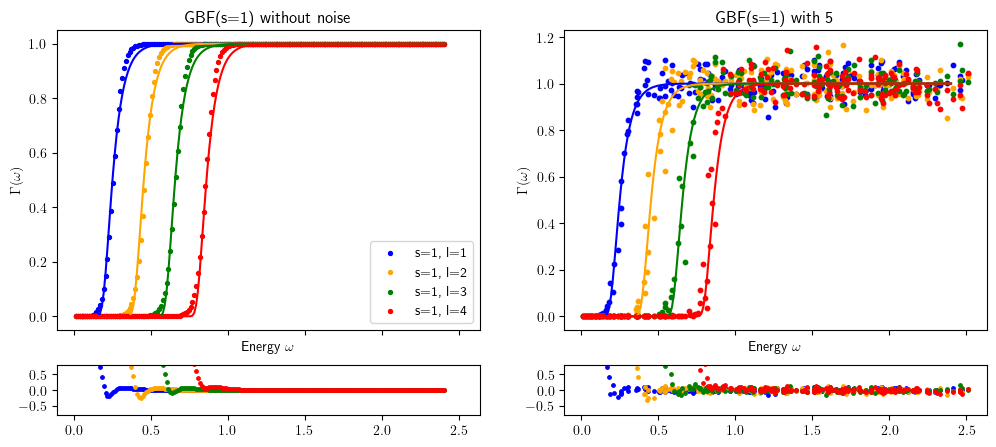

In [13]:
# def GBFsr05(x0, x1):
#     term1 = np.exp((x0/0.2026 - x1 - 0.4964)/0.2640 )
#     return erf( term1 )

def GBFsr05(x0, x1):
    term1 = np.exp(-x0/0.0609 + x1/0.29925 )
    return erfc( term1 )

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr05(s10x, 1), color='blue')
axs[0,0].plot(s10x, GBFsr05(s10x, 2), color='orange')
axs[0,0].plot(s10x, GBFsr05(s10x, 3), color='green')
axs[0,0].plot(s10x, GBFsr05(s10x, 4), color='red')

axs[0,0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr05(s10x, 1))/s10l0, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr05(s10x, 2))/s10l1, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr05(s10x, 3))/s10l2, color='green', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr05(s10x, 4))/s10l3, color='red', s=6)
axs[1,0].set_ylim(-0.8, 0.8)

axs[0,1].plot(s10x, GBFsr05(s10x, 1), color='blue')
axs[0,1].plot(s10x, GBFsr05(s10x, 2), color='orange')
axs[0,1].plot(s10x, GBFsr05(s10x, 3), color='green')
axs[0,1].plot(s10x, GBFsr05(s10x, 4), color='red')

axs[0,1].scatter(s10x_noise05, y_noise05[:, 0], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise05, y_noise05[:, 1], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise05, y_noise05[:, 2], color='green', marker='o', s=10)
axs[0,1].scatter(s10x_noise05, y_noise05[:, 3], color='red', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 5% Gaussian noise")

axs[1,1].scatter(s10x_noise05, (y_noise05[:, 0]-GBFsr05(s10x, 1))/y_noise05[:, 0], color='blue', s=6)
axs[1,1].scatter(s10x_noise05, (y_noise05[:, 1]-GBFsr05(s10x, 2))/y_noise05[:, 1], color='orange', s=6)
axs[1,1].scatter(s10x_noise05, (y_noise05[:, 2]-GBFsr05(s10x, 3))/y_noise05[:, 2], color='green', s=6)
axs[1,1].scatter(s10x_noise05, (y_noise05[:, 3]-GBFsr05(s10x, 4))/y_noise05[:, 3], color='red', s=6)
axs[1,1].set_ylim(-0.8, 0.8)

plt.show()

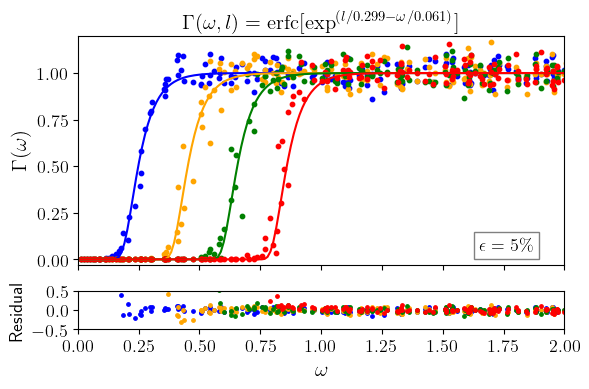

In [69]:
# def GBFsr05(x0, x1):
#     term1 = np.exp((x0/0.2026 - x1 - 0.4964)/0.2640 )
#     return erf( term1 )

def GBFsr05(x0, x1):
    term1 = np.exp(-x0/0.0609 + x1/0.29925 )
    return erfc( term1 )

fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0].plot(s10x, GBFsr05(s10x, 1), color='blue')
axs[0].plot(s10x, GBFsr05(s10x, 2), color='orange')
axs[0].plot(s10x, GBFsr05(s10x, 3), color='green')
axs[0].plot(s10x, GBFsr05(s10x, 4), color='red')

axs[0].scatter(s10x_noise05, y_noise05[:, 0], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise05, y_noise05[:, 1], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise05, y_noise05[:, 2], color='green', marker='o', s=10)
axs[0].scatter(s10x_noise05, y_noise05[:, 3], color='red', marker='o', s=10)
axs[0].set_xlim(0, 2)
axs[0].set_ylim(-0.03, 1.2)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.65, 0.05, r'$\epsilon=5\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erfc}[{\rm exp}^{(l/0.299 -\omega /0.061 )} ]$', fontsize=15)

axs[1].scatter(s10x_noise05, (y_noise05[:, 0]-GBFsr05(s10x, 1))/y_noise05[:, 0], color='blue', s=6)
axs[1].scatter(s10x_noise05, (y_noise05[:, 1]-GBFsr05(s10x, 2))/y_noise05[:, 1], color='orange', s=6)
axs[1].scatter(s10x_noise05, (y_noise05[:, 2]-GBFsr05(s10x, 3))/y_noise05[:, 2], color='green', s=6)
axs[1].scatter(s10x_noise05, (y_noise05[:, 3]-GBFsr05(s10x, 4))/y_noise05[:, 3], color='red', s=6)
axs[1].set_xlabel("$\omega$", fontsize=15)
axs[1].set_ylabel("Residual", fontsize=13)
axs[1].set_ylim(-0.5, 0.5)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err5.pdf", bbox_inches='tight')
plt.show()

## 1% noise level in both $\Omega_i$ and $\Gamma_i$

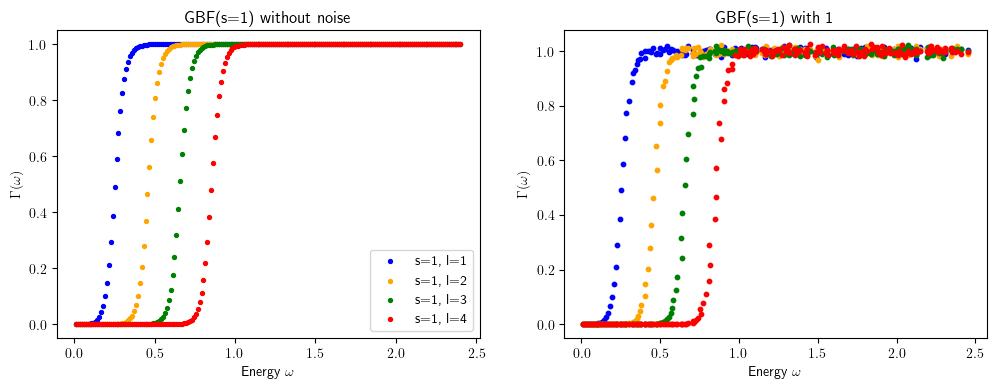

In [15]:
# Define Gaussian noise
mean = 0 
std_dev1 = 0.01  # 1% noise level in both omega and GBF
s10x_noise1 = s10x + np.random.normal(mean, std_dev1*s10x)
y1_noise1 = s10l0 + np.random.normal(mean, std_dev1*s10l0, size=s10l0.shape)
y2_noise1 = s10l1 + np.random.normal(mean, std_dev1*s10l1, size=s10l1.shape)
y3_noise1 = s10l2 + np.random.normal(mean, std_dev1*s10l2, size=s10l2.shape)
y4_noise1 = s10l3 + np.random.normal(mean, std_dev1*s10l3, size=s10l3.shape)
y_noise1 = np.column_stack((y1_noise1, y2_noise1, y3_noise1, y4_noise1)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise1, y_noise1[:, 0], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise1, y_noise1[:, 1], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise1, y_noise1[:, 2], color='green', marker='o', s=10)
axs[1].scatter(s10x_noise1, y_noise1[:, 3], color='red', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with 1% Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 1% errorbar

In [16]:
 # Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise1, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise1.flatten()

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model1 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model1.fit(input_data, y_flat)

/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.160e+05
Head worker occupation: 7.9%
Progress: 734 / 7500 total iterations (9.787%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.305e-01  1.594e+01  y = x₀
3           1.647e-01  4.805e-01  y = -0.41356 + 1.1835
4           5.642e-02  1.071e+00  y = sin(x₀)
5           5.020e-02  1.168e-01  y = erf(x₀)
7           4.913e-02  1.083e-02  y = erf(-0.05424 + x₀)
8           4.910e-02  5.281e-04  y = sin(x₀ - 0.13264) - -0.087447
9           4.776e-02  2.775e-02  y = erf(x₀ - 0.11607) + 0.05379
10          4.175e-02  1.343e-01  y = erf((x₀ + x₀) / x₁)
11          3.332e-02  2.257e-01  y = erf((2.6298 / x₁) * x₀)
12          2.671e-02  2.210e-01  y = erf(((x₀ + 3.4991) - x₁) * x₀)
13          2.146e-02  2.187e-01  y = erf(((x₀ / 0.25331) / x₁) - 0.33208)
14          1.914e-02  1.147e-01  y = erf((3.9245 * (x₀ / x₁)) * x₀)
15        

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.76997614   
	1         0.356989                                            sin(x0)   
	2         0.116800                                            erf(x0)   
	3         0.010833                              erf(-0.05424008 + x0)   
	4         0.000528                 0.08744751 + sin(x0 + -0.13263875)   
	5         0.027751                 erf(x0 - 0.11607378) + 0.053789854   
	6         0.134329                                erf((x0 + x0) / x1)   
	7         0.225676                           erf((2.62984 / x1) * x0)   
	8         0.221009                  erf(((x0 + 3.4991138) - x1) * x0)   
	9         1.820098                    erf(exp(3.8302524 - (x1 / x0)))   
	10        0.314484               erf(exp((3.13708 + x0) - (x1 / x0)))   
	11        0.097855             erf(exp((4.0175533 - (x1 / x0)) / x0))   
	12        1.116409  erf(exp(9.3063965 - ((x1 + (0.63159627 + x1)) ...   
	13  >>>>  0.515925  erf(exp((((x0 / 0.19997661) - 0.51007015) - x1...   
	14        0.010387  erf(exp((((x0 / 0.19997661) - 0.51409256) - x1...   
	
	        loss  complexity  
	0   0.164650           1  
	1   0.056422           4  
	2   0.050202           5  
	3   0.049126           7  
	4   0.049100           8  
	5   0.047756           9  
	6   0.041754          10  
	7   0.033318          11  
	8   0.026712          12  
	9   0.004328          13  
	10  0.002307          15  
	11  0.002092          16  
	12  0.000685          17  
	13  0.000409          18  
	14  0.000401          20  
]

In [17]:
SchGBF_model1.sympy()

erf(exp((x0/0.19997661 - x1 - 1*0.51007015)/0.25867307))

### The fitting result of SR with 1%

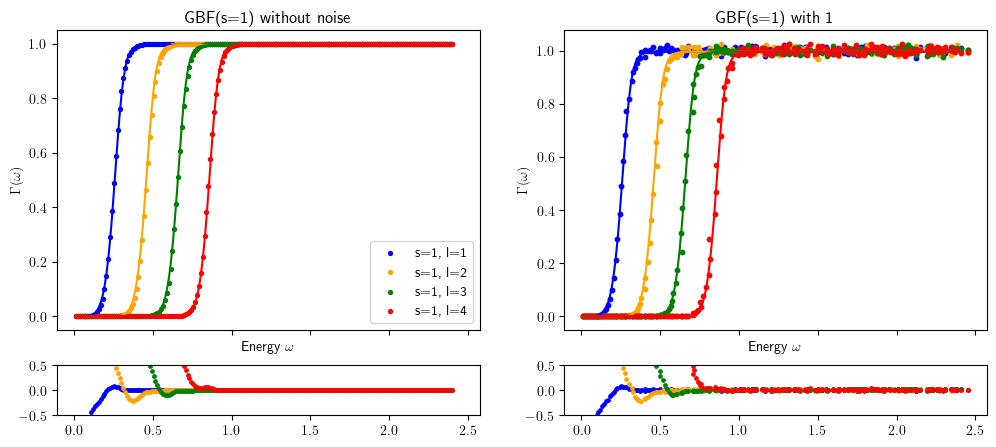

In [18]:
def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )

# def GBFsr1(x0, x1):
#     term1 = np.exp(4.8838*x1 - x1*x1/x0 - 1.7451 )
#     return erf(term1)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr1(s10x, 1), color='blue')
axs[0,0].plot(s10x, GBFsr1(s10x, 2), color='orange')
axs[0,0].plot(s10x, GBFsr1(s10x, 3), color='green')
axs[0,0].plot(s10x, GBFsr1(s10x, 4), color='red')

axs[0,0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr1(s10x, 1))/s10l0, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr1(s10x, 2))/s10l1, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr1(s10x, 3))/s10l2, color='green', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr1(s10x, 4))/s10l3, color='red', s=6)
axs[1,0].set_ylim(-0.5, 0.5)

axs[0,1].plot(s10x, GBFsr1(s10x, 1), color='blue')
axs[0,1].plot(s10x, GBFsr1(s10x, 2), color='orange')
axs[0,1].plot(s10x, GBFsr1(s10x, 3), color='green')
axs[0,1].plot(s10x, GBFsr1(s10x, 4), color='red')

axs[0,1].scatter(s10x_noise1, y_noise1[:, 0], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise1, y_noise1[:, 1], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise1, y_noise1[:, 2], color='green', marker='o', s=10)
axs[0,1].scatter(s10x_noise1, y_noise1[:, 3], color='red', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 1% Gaussian noise")

axs[1,1].scatter(s10x_noise1, (y_noise1[:, 0]-GBFsr1(s10x, 1))/y_noise1[:, 0], color='blue', s=6)
axs[1,1].scatter(s10x_noise1, (y_noise1[:, 1]-GBFsr1(s10x, 2))/y_noise1[:, 1], color='orange', s=6)
axs[1,1].scatter(s10x_noise1, (y_noise1[:, 2]-GBFsr1(s10x, 3))/y_noise1[:, 2], color='green', s=6)
axs[1,1].scatter(s10x_noise1, (y_noise1[:, 3]-GBFsr1(s10x, 4))/y_noise1[:, 3], color='red', s=6)
axs[1,1].set_ylim(-0.5, 0.5)

plt.show()

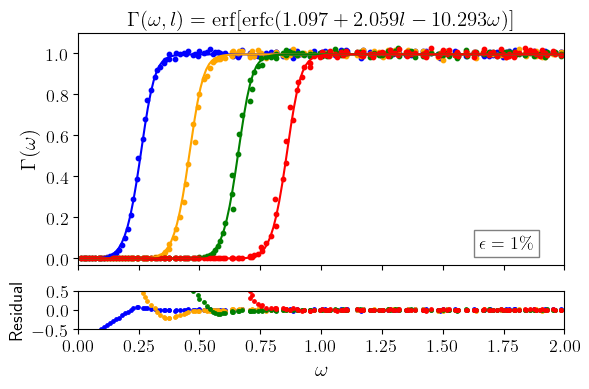

In [ ]:
def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )

# def GBFsr1(x0, x1):
#     term1 = np.exp(4.8838*x1 - x1*x1/x0 - 1.7451 )
#     return erf(term1)

fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0].plot(s10x, GBFsr1(s10x, 1), color='blue')
axs[0].plot(s10x, GBFsr1(s10x, 2), color='orange')
axs[0].plot(s10x, GBFsr1(s10x, 3), color='green')
axs[0].plot(s10x, GBFsr1(s10x, 4), color='red')

axs[0].scatter(s10x_noise1, y_noise1[:, 0], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise1, y_noise1[:, 1], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise1, y_noise1[:, 2], color='green', marker='o', s=10)
axs[0].scatter(s10x_noise1, y_noise1[:, 3], color='red', marker='o', s=10)
axs[0].set_xlim(0, 2)
axs[0].set_ylim(-0.03, 1.1)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.65, 0.05, r'$\epsilon=1\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erf}[{\rm erfc}(1.097 + 2.059 l -10.293\omega ) ]$', fontsize=15)

axs[1].scatter(s10x_noise1, (y_noise1[:, 0]-GBFsr1(s10x, 1))/y_noise1[:, 0], color='blue', s=6)
axs[1].scatter(s10x_noise1, (y_noise1[:, 1]-GBFsr1(s10x, 2))/y_noise1[:, 1], color='orange', s=6)
axs[1].scatter(s10x_noise1, (y_noise1[:, 2]-GBFsr1(s10x, 3))/y_noise1[:, 2], color='green', s=6)
axs[1].scatter(s10x_noise1, (y_noise1[:, 3]-GBFsr1(s10x, 4))/y_noise1[:, 3], color='red', s=6)
axs[1].set_xlabel("$\omega$", fontsize=15)
axs[1].set_ylabel("Residual", fontsize=13)
axs[1].set_ylim(-0.5, 0.5)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err1.pdf", bbox_inches='tight')
plt.show()

## 0.1% noise level in both $\Omega_i$ and $\Gamma_i$

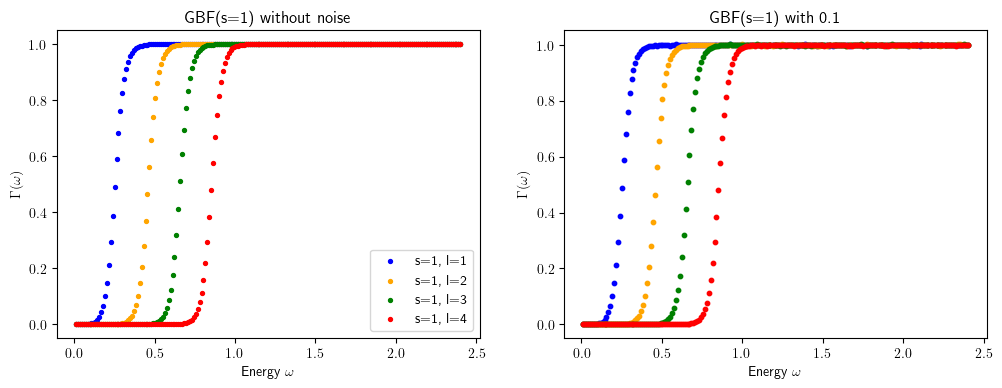

In [20]:
# Define Gaussian noise
mean = 0 
std_dev01 = 0.001  # 10% noise level in both omega and GBF
s10x_noise01 = s10x + np.random.normal(mean, std_dev01*s10x)
y1_noise01 = s10l0 + np.random.normal(mean, std_dev01*s10l0, size=s10l0.shape)
y2_noise01 = s10l1 + np.random.normal(mean, std_dev01*s10l1, size=s10l1.shape)
y3_noise01 = s10l2 + np.random.normal(mean, std_dev01*s10l2, size=s10l2.shape)
y4_noise01 = s10l3 + np.random.normal(mean, std_dev01*s10l3, size=s10l3.shape)
y_noise01 = np.column_stack((y1_noise01, y2_noise01, y3_noise01, y4_noise01)) # from (100, 1) to (100,4)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0].set_xlabel("Energy $\omega$")
axs[0].set_ylabel("$\Gamma (\omega)$")
axs[0].set_title("GBF(s=1) without noise")
axs[0].legend()

axs[1].scatter(s10x_noise01, y_noise01[:, 0], color='blue', marker='o', s=10)
axs[1].scatter(s10x_noise01, y_noise01[:, 1], color='orange', marker='o', s=10)
axs[1].scatter(s10x_noise01, y_noise01[:, 2], color='green', marker='o', s=10)
axs[1].scatter(s10x_noise01, y_noise01[:, 3], color='red', marker='o', s=10)
axs[1].set_xlabel("Energy $\omega$")
axs[1].set_ylabel("$\Gamma (\omega)$")
axs[1].set_title("GBF(s=1) with 0.1% Gaussian noise")
# axs[1].legend()

plt.show()

### PySR for 0.1% errorbar

In [21]:
 # Step 1: Generate sample data
l_values = np.array([1, 2, 3, 4])
x_grid, l_grid = np.meshgrid(s10x_noise01, l_values, indexing='ij')

# Step 2: Flatten the grid to create a dataset with shape (100*4, 2)
x_flat = x_grid.flatten()  # shape (400, )
l_flat = l_grid.flatten()  # shape (400, )
input_data = np.column_stack((x_flat, l_flat))  # Shape: (400, 2)

y_flat = y_noise01.flatten()

# Step 4: Set up and run the PySR symbolic regression
SchGBF_model01 = PySRRegressor(
    niterations=500,
    binary_operators = ["+", "-", "*", "/"],
    unary_operators = ["sin", "cos", "exp", "log", "erf", "erfc"], # round/ceil/floor are Optional for discrete handling
    complexity_of_operators={"+": 1, "-": 1,"*": 2, "/": 2, "sin": 3, "cos": 3, "exp": 3, "log": 3, "erf": 4,"erfc": 4}, # set custom complexities
)

# Step 5: Fit the model
SchGBF_model01.fit(input_data, y_flat)

/Users/yuangw/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.140e+05
Head worker occupation: 7.9%
Progress: 723 / 7500 total iterations (9.640%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.615e+00  1.594e+01  y = x₁
3           1.646e-01  1.667e+00  y = 0.24023 + 0.52988
4           5.620e-02  1.074e+00  y = sin(x₀)
5           5.008e-02  1.152e-01  y = erf(x₀)
7           4.902e-02  1.070e-02  y = erf(x₀ + -0.05387)
8           4.890e-02  2.523e-03  y = sin(x₀ + -0.13198) - -0.087299
9           4.766e-02  2.554e-02  y = erf(-0.11544 + x₀) - -0.053516
10          4.167e-02  1.344e-01  y = erf((x₀ + x₀) / x₁)
11          3.318e-02  2.278e-01  y = erf((x₀ / x₁) / 0.37988)
12          2.653e-02  2.238e-01  y = erf((x₀ - (-3.4989 + x₁)) * x₀)
13          2.212e-02  1.820e-01  y = erf(((x₀ / x₁) / 0.28108) - 0.28108)
14          1.566e-02  3.450e-01  y = erf((x₀ - ((-2.6996 + x₁) - x₀)) * 

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.7701396   
	1         0.358147                                            sin(x0)   
	2         0.115235                                            erf(x0)   
	3         0.010700                             erf(x0 + -0.053870156)   
	4         0.002523                 sin(x0 + -0.1319785) - -0.08729945   
	5         0.025537                erf(x0 + -0.11543383) + 0.053514756   
	6         0.134405                                erf((x0 + x0) / x1)   
	7         0.227765                        erf((x0 / x1) / 0.37987638)   
	8         0.223804                 erf((x0 - (-3.4988565 + x1)) * x0)   
	9         1.843199                    erf(exp(3.8321288 - (x1 / x0)))   
	10        0.326757             erf(exp(8.2789345 - ((x1 + x1) / x0)))   
	11        0.089443             erf(exp((4.0282187 - (x1 / x0)) / x0))   
	12        1.297207  erf(exp(9.269741 - (((x1 + x1) + 0.6098667) / ...   
	13  >>>>  0.973588  erf(exp((x0 - ((x1 * 0.20021215) - -0.10046093...   
	14        0.016335  erf(exp((x0 - ((0.50223166 + x1) * 0.20027235)...   
	
	        loss  complexity  
	0   0.164569           1  
	1   0.056198           4  
	2   0.050082           5  
	3   0.049021           7  
	4   0.048898           8  
	5   0.047665           9  
	6   0.041670          10  
	7   0.033182          11  
	8   0.026528          12  
	9   0.004200          13  
	10  0.002185          15  
	11  0.001998          16  
	12  0.000546          17  
	13  0.000206          18  
	14  0.000200          20  
]

In [22]:
SchGBF_model01.sympy()

erf(exp((x0 - (x1*0.20021215 - 1*(-0.10046093)))/0.05148752))

### The fitting result of SR with 0.1%

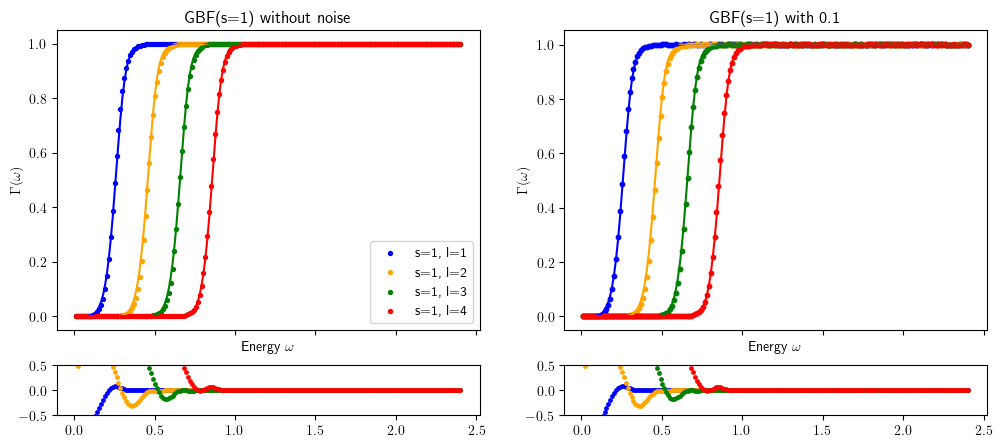

In [23]:
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))

# def GBFsr01(x0, x1):
#     term1 = np.exp(x0/0.0510 - x1/0.2543 - 1.940)
#     return erf (term1)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0,0].plot(s10x, GBFsr01(s10x, 1), color='blue')
axs[0,0].plot(s10x, GBFsr01(s10x, 2), color='orange')
axs[0,0].plot(s10x, GBFsr01(s10x, 3), color='green')
axs[0,0].plot(s10x, GBFsr01(s10x, 4), color='red')

axs[0,0].scatter(s10x, s10l0, color= 'blue', s=8, label='s=1, l=1')
axs[0,0].scatter(s10x, s10l1, color= 'orange', s=8, label='s=1, l=2')
axs[0,0].scatter(s10x, s10l2, color= 'green', s=8, label='s=1, l=3')
axs[0,0].scatter(s10x, s10l3, color= 'red', s=8, label='s=1, l=4')
axs[0,0].set_xlabel("Energy $\omega$")
axs[0,0].set_ylabel("$\Gamma (\omega)$")
axs[0,0].set_title("GBF(s=1) without noise")
axs[0,0].legend()

axs[1,0].scatter(s10x, (s10l0-GBFsr01(s10x, 1))/s10l0, color='blue', s=6)
axs[1,0].scatter(s10x, (s10l1-GBFsr01(s10x, 2))/s10l1, color='orange', s=6)
axs[1,0].scatter(s10x, (s10l2-GBFsr01(s10x, 3))/s10l2, color='green', s=6)
axs[1,0].scatter(s10x, (s10l3-GBFsr01(s10x, 4))/s10l3, color='red', s=6)
axs[1,0].set_ylim(-0.5, 0.5)

axs[0,1].plot(s10x, GBFsr01(s10x, 1), color='blue')
axs[0,1].plot(s10x, GBFsr01(s10x, 2), color='orange')
axs[0,1].plot(s10x, GBFsr01(s10x, 3), color='green')
axs[0,1].plot(s10x, GBFsr01(s10x, 4), color='red')

axs[0,1].scatter(s10x_noise01, y_noise01[:, 0], color='blue', marker='o', s=10)
axs[0,1].scatter(s10x_noise01, y_noise01[:, 1], color='orange', marker='o', s=10)
axs[0,1].scatter(s10x_noise01, y_noise01[:, 2], color='green', marker='o', s=10)
axs[0,1].scatter(s10x_noise01, y_noise01[:, 3], color='red', marker='o', s=10)
axs[0,1].set_xlabel("Energy $\omega$")
axs[0,1].set_ylabel("$\Gamma (\omega)$")
axs[0,1].set_title("GBF(s=1) with 0.1% Gaussian noise")

axs[1,1].scatter(s10x_noise01, (y_noise01[:, 0]-GBFsr01(s10x, 1))/y_noise01[:, 0], color='blue', s=6)
axs[1,1].scatter(s10x_noise01, (y_noise01[:, 1]-GBFsr01(s10x, 2))/y_noise01[:, 1], color='orange', s=6)
axs[1,1].scatter(s10x_noise01, (y_noise01[:, 2]-GBFsr01(s10x, 3))/y_noise01[:, 2], color='green', s=6)
axs[1,1].scatter(s10x_noise01, (y_noise01[:, 3]-GBFsr01(s10x, 4))/y_noise01[:, 3], color='red', s=6)
axs[1,1].set_ylim(-0.5, 0.5)

plt.show()

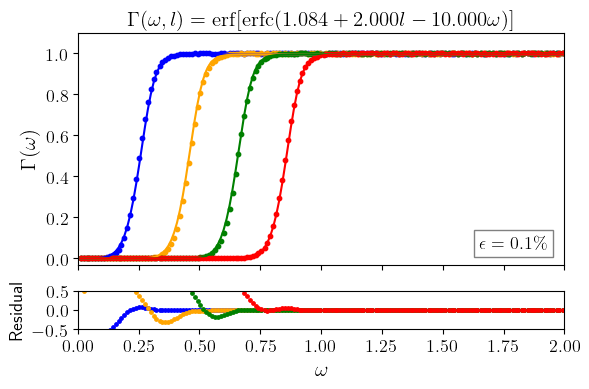

In [65]:
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))

# def GBFsr01(x0, x1):
#     term1 = np.exp(x0/0.0510 - x1/0.2543 - 1.940)
#     return erf (term1)

fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

axs[0].plot(s10x, GBFsr01(s10x, 1), color='blue')
axs[0].plot(s10x, GBFsr01(s10x, 2), color='orange')
axs[0].plot(s10x, GBFsr01(s10x, 3), color='green')
axs[0].plot(s10x, GBFsr01(s10x, 4), color='red')

axs[0].scatter(s10x_noise01, y_noise01[:, 0], color='blue', marker='o', s=10)
axs[0].scatter(s10x_noise01, y_noise01[:, 1], color='orange', marker='o', s=10)
axs[0].scatter(s10x_noise01, y_noise01[:, 2], color='green', marker='o', s=10)
axs[0].scatter(s10x_noise01, y_noise01[:, 3], color='red', marker='o', s=10)
axs[0].set_xlim(0, 2)
axs[0].set_ylim(-0.03, 1.1)
axs[0].set_ylabel("$\Gamma (\omega)$", fontsize=15)
axs[0].text(1.65, 0.05, r'$\epsilon =0.1\%$', fontsize=13, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='square,pad=0.3'))
axs[0].set_title(r'$\Gamma (\omega, l) = {\rm erf}[{\rm erfc}(1.084 + 2.000 l -10.000\omega ) ]$', fontsize=15)

axs[1].scatter(s10x_noise01, (y_noise01[:, 0]-GBFsr01(s10x, 1))/y_noise01[:, 0], color='blue', s=6)
axs[1].scatter(s10x_noise01, (y_noise01[:, 1]-GBFsr01(s10x, 2))/y_noise01[:, 1], color='orange', s=6)
axs[1].scatter(s10x_noise01, (y_noise01[:, 2]-GBFsr01(s10x, 3))/y_noise01[:, 2], color='green', s=6)
axs[1].scatter(s10x_noise01, (y_noise01[:, 3]-GBFsr01(s10x, 4))/y_noise01[:, 3], color='red', s=6)
axs[1].set_xlabel("$\omega$", fontsize=15)
axs[1].set_ylabel("Residual", fontsize=13)
axs[1].set_ylim(-0.5, 0.5)

axs[1].tick_params('x', labelsize=13)
axs[0].tick_params('y', labelsize=13)
axs[1].tick_params('y', labelsize=13)

plt.tight_layout()
plt.savefig("err01.pdf", bbox_inches='tight')
plt.show()

## Spectrum

In [25]:
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))


def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )


def GBFsr05(x0, x1):
    term1 = np.exp((x0/0.2026 - x1 - 0.4964)/0.2640 )
    return erf( term1 )


def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )

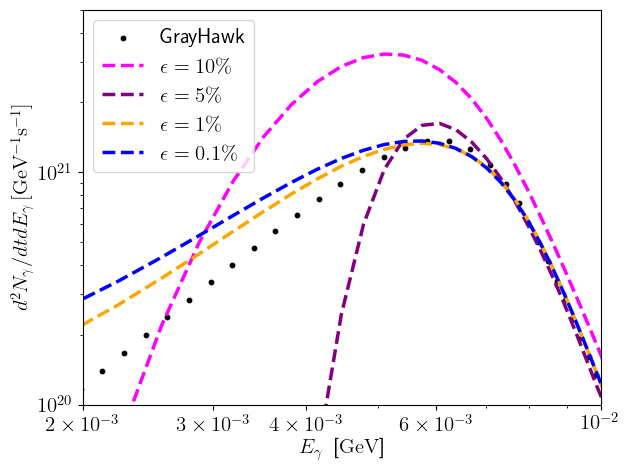

In [35]:
hplanck = 6.6260700404e-34  	#Joule*sec
hbar = hplanck/6.283185
clight = 299792458              #m/sec 
kb = 1.38064852e-23			    #Joule/K
G_Newtonian = 6.673*1e-11       #gravity, m^3/kg/s^2

J2GeV = 6.242*1e9               #Joule to GeV
K2GeV = 8.617*1e-14             #Kelvin to GeV
hbarGeV = hbar * J2GeV          #GeV * sec
Invhbar = 1.0/hbar              #Joule^-1*sec-1
InvhbarGeV = Invhbar / J2GeV

residual_cut = 0.25

def temperature(mass): #Hawking temperature, input unit is kg
    return hbar * clight**3 / (8 * np.pi * G_Newtonian * kb * mass) * K2GeV # kelvin to GeV

def energy(omega, mass):
    factor = hbar * clight**3 /(G_Newtonian*mass) * J2GeV  # GeV
    return omega * factor

def sum_gamma10(omega, mass):
    k0=1/4
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2*sum((2*(l+1) + 1) * s10_array[l] / (np.exp(2*np.pi*omega/k0) - 1) for l in range(4) )/(2*np.pi) 
    return result * InvhbarGeV

def spectra(omega, mass):
    temp = temperature(mass) #GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV 
    result = 2*sum((2*(l+1) + 1) * s10_array[l] / (np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV  


def manualfit(omega, l):
    a = -0.790
    b = -2.770
    c = 13.847
    hr = 0.5 * (erf(a + b*l + c*omega) + 1)   # model values
    nn = s10_array[:, l-1]   # numerical values

    residual = np.abs(nn-hr)/nn
    mask = np.cumsum(residual < residual_cut) < 0
    return  np.where(mask, 0, hr)  


def spectra_TP(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * manualfit(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


#################################################################
def GBFsr01(x0, x1):
    return erf(erfc (-10.00055*x0 + 2*x1 + 1.08366))


def GBFsr1(x0, x1):
    return erf(erfc(1.097 + 2.059*x1 -10.293*x0 ) )

def GBFsr05(x0, x1):
    term1 = np.exp(-x0/0.0609 + x1/0.29925 )
    return erfc( term1 )

def GBFsr10(x0, x1):
    return erf(np.exp(3.8094 - x1/x0) )


def spectra_sr01(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr01(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


def spectra_sr1(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr1(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


def spectra_sr05(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr05(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV


def spectra_sr10(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * GBFsr10(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV

###################################################################

schwarzschild_spectra = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/schwarzschild_spectra.csv", header=None, names=['x1', 'y1'])
x1 = schwarzschild_spectra['x1'].values
y1 = schwarzschild_spectra['y1'].values
energy_ini = np.logspace(np.log10(x1.min()), np.log10(x1.max()), 200)  # Define energy1 grid

plt.scatter(x1, y1, color='black', s=10, label='GrayHawk')
plt.plot(energy(s10x, 1e13), spectra_sr10(s10x, 1e13), color='magenta', linestyle='--', linewidth=2.5, label=r'$\epsilon=10\% $')
plt.plot(energy(s10x, 1e13), spectra_sr05(s10x, 1e13), color='purple', linestyle='--', linewidth=2.5, label=r'$\epsilon=5\% $')
plt.plot(energy(s10x, 1e13), spectra_sr1(s10x, 1e13), color='orange', linestyle='--', linewidth=2.5, label=r'$\epsilon=1\% $')
plt.plot(energy(s10x, 1e13), spectra_sr01(s10x, 1e13), color='blue', linestyle='--', linewidth=2.5, label=r'$\epsilon=0.1\% $')
plt.xscale("log")
plt.yscale("log")
plt.xlim(2e-3, 1e-2)
plt.ylim(1e20, 5e21)

plt.xticks([2.e-3, 3.e-3, 4.e-3, 6.e-3, 1.e-2], labels=[r'$2\times10^{-3}$', r'$3\times10^{-3}$', r'$4\times10^{-3}$', r'$6\times10^{-3}$', r'$10^{-2}$'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$E_{\gamma}$\, [{\rm GeV}]', fontsize=15)
plt.ylabel(r'$d^2N_{\gamma}/dtdE_{\gamma}\, [\rm GeV^{-1}s^{-1}]$', fontsize=15)
# plt.title('Mass=10^13kg')
plt.legend(fontsize=15, loc ='upper left')

plt.tight_layout()
plt.savefig("sr_with_errors.pdf", bbox_inches='tight')
plt.show()